# Computing the characteristic impedance of transmission lines using Tidy3D

In this tutorial notebook, we explore the use of Tidy3D to compute the characteristic impedance of transmission lines. The characteristic impedance is a fundamental parameter in the design of transmission lines that affects signal integrity and power distribution. This notebook also serves to introduce [LumpedElements](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/lumped_elements.html) and path integrals, which are components that are used to set up [LumpedPorts](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.LumpedPort.html#tidy3d.plugins.smatrix.LumpedPort) in the [smatrix](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/plugins/smatrix.html) plugin.

The microstrip, a type of transmission line with a conductor strip separated from a ground plane by a dielectric layer, will serve as our example for the study. We will demonstrate how to use the post processing tools available in the `microwave` plugin to determine the voltage and current distribution along the microstrip both in the time and frequency domains.

The notebook is structured as follows:
- Set up structures and simulation parameters for a microstrip transmission line.
- Computation of the voltage and current using path integrals.
- Calculation of the characteristic impedance.
- Final simulation of a microstrip terminated by a matched load.

By the end of this notebook, you will have a clear understanding of how to use Tidy3D for simulating and analyzing the characteristic impedance of transmission lines, as well as many of the building blocks used within microwave simulations.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# tidy3D imports
import tidy3d as td
from tidy3d import web
import tidy3d.plugins.microwave as microwave

# We set the logging level to "ERROR". Otherwise there are numerous warnings due to the proximity of the structure to PML boundaries.
td.config.logging_level = "ERROR"

## Setting up a Microstrip Simulation

The microstrip transmission line that we wish to characterize is presented below. It is characterized by a `width`, `height`, `thickness`, and substrate electric permittivity $\epsilon_r$. For simplicity, conductors are assumed to be perfect electric conductors, and the microstrip will be modeled with an infinitesimally small `thickness`, which we will implement using a `Medium2D`.

<img src="img/microstrip_geometry.svg" width=800 alt="Schematic of the microstrip">

We can also simplify the simulation by using a PEC boundary condition at the $z$ minimum boundary, which will model the effect of the ground plane.

In [2]:
#Frequency range of interest is from 0.1 GHz to 10 GHz
freq_start = 1e8
freq_stop = 100e8
freq0 = (freq_stop) / 2
fwidth = freq_stop - freq_start
wavelength0 = td.C_0 / freq0
freqs = np.linspace(freq_start, freq_stop, 100)

# Fields should decay rapidly in this notebook, since we are using PMLs.
# Later we will use a matched load that also quickly dissipates power.
run_time = 60 / fwidth

gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)

# Default units in Tidy3D are microns
mm = 1e3
# Microstrip parameters (thickness is assumed 0)
length = 40 * mm
width = 3 * mm
height = 1 * mm
thickness = 0.0

# Size and offset of simulation, so that the microstrip will terminate inside the PML
sim_size = (length + wavelength0 / 2, 3 * width + wavelength0 / 2, height + wavelength0 / 2)
sim_center = (-sim_size[0] / 2 + length / 4, 0, sim_size[2] / 2)

# Conductors are assumed to be perfect electric conductors
# Substrate has permittivity of 4.4
air = td.Medium()
pec = td.PECMedium()
pec2d = td.Medium2D(ss=pec, tt=pec)
diel = td.Medium(permittivity=4.4)

# Create a structure representing a microstrip along the x axis
strip_center = (0, 0, height+thickness/2)
strip = td.Structure(
    geometry=td.Box(
        center=strip_center,
        size=[length, width, thickness],
    ),
    medium=pec2d,
)

# Create a structure representing the substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, 2*height],
    ),
    medium=diel,
)

# Use a refined mesh near the microstrip, where the fields are mostly contained
dl = width / 50
mesh_overrides = [
    td.MeshOverrideStructure(
        geometry=td.Box(
            center=strip_center,
            size=[length + 2 * width, 4 * width, 4 * height],
        ),
        dl=[dl, dl, dl],
    )
]

# Place an excitation at the left (x min) side of the microstrip
uniform_current = td.UniformCurrentSource(
    center=(-length / 2, 0, height / 2),
    size=(0, width, height),
    source_time=gaussian,
    polarization="Ez",
    name="current",
    interpolate=True,
    confine_to_bounds=True,
)

### Initialize monitors and finalize simulation

The voltage and current along the microstrip can be computed by exciting the transmission line using a `UniformCurrentSource`. The source will excite the transmission line mode, which we can then analyze using field monitors in the transverse plane.

In the transverse plane (yz), the fields of the microstrip line are quasi-TEM, which allows for unique definitions of voltage and current [1].

The voltage can be computed by defining a path from the ground to the strip and applying the equation
$$
V_{ab} = V_{a} - V_{b} = - \int^a_b  \mathbf{E} \cdot \mathbf{dl}.
$$

Similarly, to determine the current flowing in the strip along the x axis, we may use Ampère's circuital law
$$
I = \oint_C  \mathbf{H} \cdot \mathbf{dl},
$$
where the path is a closed contour surrounding the strip.

The integration paths are shown in the figure below:

<img src="img/microstrip_paths.svg" width=800 alt="Schematic of the microstrip with path integrals">

In order to perform these computations, we need to set up the `Tidy3D` simulation to record the electric and magnetic fields at these locations. One option would be to use one monitor that is large enough to encompass both integration paths. We can also choose two monitors that will be independently used for the voltage and current computations.

In the next cell, monitors for recording the time domain and frequency domain fields are created. An additional monitor is added for plotting the field along the direction of propagation.

In [3]:
# Define all monitors in the simulation

# Monitor for plotting the field along the axis of propagation
propagate_mon = td.FieldMonitor(
    center=[0, 0, height / 2],
    size=[length + 4 * width, 4 * width, 0],
    freqs=[freq0],
    name="propagate",
)

# Frequency domain monitor for computing both voltage and current
freq_yz = td.FieldMonitor(
    center=[0, 0, 2 * height],
    size=[0, 4 * width, 4 * height],
    freqs=freqs,
    name="freq_yz",
)

# Time monitor for computing voltage
time_voltage_yz = td.FieldTimeMonitor(
    center=[0, 0, height / 2],
    size=[0, 0, height],
    fields=["Ez"],
    interval=40,
    name="time_voltage_yz",
)

# Time monitor for computing current
time_current_yz = td.FieldTimeMonitor(
    center=strip_center,
    size=[0, width + 500, thickness + 500],
    fields=["Hy", "Hz"],
    interval=40,
    name="time_current_yz",
)

Now, the simulation is set up using the created components. Before running the simulation we also plot the structure.

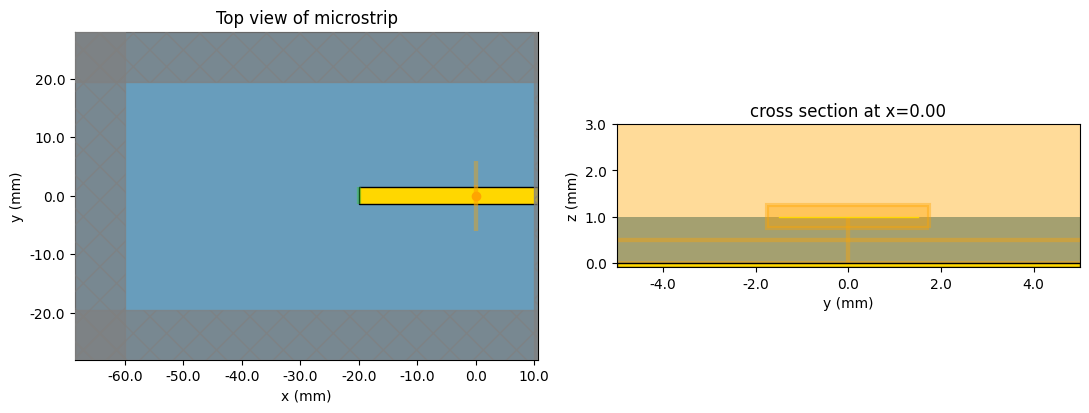

In [4]:
# Using PMLs on every boundary, except for the minus z boundary
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary(plus=td.PML(), minus=td.PECBoundary()),
)

# Simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,
        wavelength=td.C_0 / freq_stop,
        override_structures=mesh_overrides,
    ),
    structures=[substrate, strip],
    sources=[uniform_current],
    monitors=[propagate_mon, freq_yz, time_voltage_yz, time_current_yz],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

# Formatter to aid plotting in units of millimeters
formatter = ticker.FuncFormatter(lambda y, _: f"{(1e-3) * y}")


def update_axis_with_format(axis, format, xlbl, ylbl):
    axis.set_xlabel(xlbl)
    axis.set_ylabel(ylbl)
    axis.xaxis.set_major_formatter(format)
    axis.yaxis.set_major_formatter(format)


# Plot the current simulation setup and scale to millimeters
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))

sim.plot(z=height, ax=ax1)
sim.plot(x=0, ax=ax2, vlim=[0, 3 * mm], hlim=[-5 * mm, 5 * mm])
update_axis_with_format(ax1, formatter, "x (mm)", "y (mm)")
ax1.set_title("Top view of microstrip")
update_axis_with_format(ax2, formatter, "y (mm)", "z (mm)")

plt.show()

### Running the simulation

In [5]:
sim_data = web.run(sim, "impedance_calc")

12:00:31 UTC Created task 'impedance_calc' with task_id                         
             'fdve-280688fe-52f1-4940-993e-4b82637e8fa2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=77207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=415332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\taskId]8;;\]8;id=77207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\=]8;;\]8;id=752996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\fdve]8;;\]8;id=77207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\-280688fe-52f]8;;\
             ]8;id=77207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\1-4940-993e-4b82637e8fa2']8;;\.

Output()

12:00:33 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:00:39 UTC status = preprocess

12:00:40 UTC Maximum FlexCredit cost: 0.379. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:00:48 UTC early shutoff detected at 8%, exiting.

             status = postprocess

Output()

12:01:01 UTC status = success

             View simulation result at                                          
             ]8;id=774080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=181178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\taskId]8;;\]8;id=774080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\=]8;;\]8;id=785284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\fdve]8;;\]8;id=774080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\-280688fe-52f]8;;\
             ]8;id=774080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-280688fe-52f1-4940-993e-4b82637e8fa2\1-4940-993e-4b82637e8fa2']8;;\.

Output()

12:01:04 UTC loading simulation from simulation_data.hdf5

Next, we plot the electric field along the microstrip demonstrating that the transmission line mode has been excited properly. The fields in the transverse plane are presented in the second set of plots. Although the longitudinal field $\mathrm{E}_x$ is not zero, it is two orders of magnitude smaller than the dominant transverse field, which validates the quasi-TEM approximation.

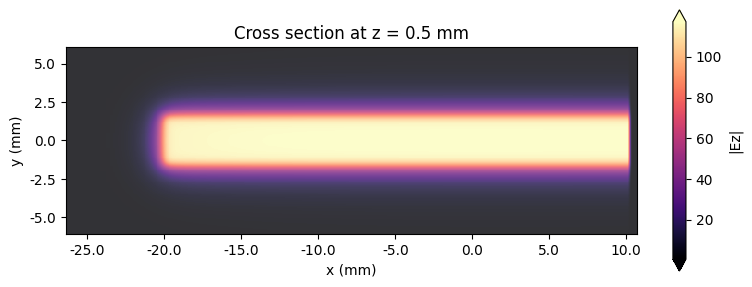

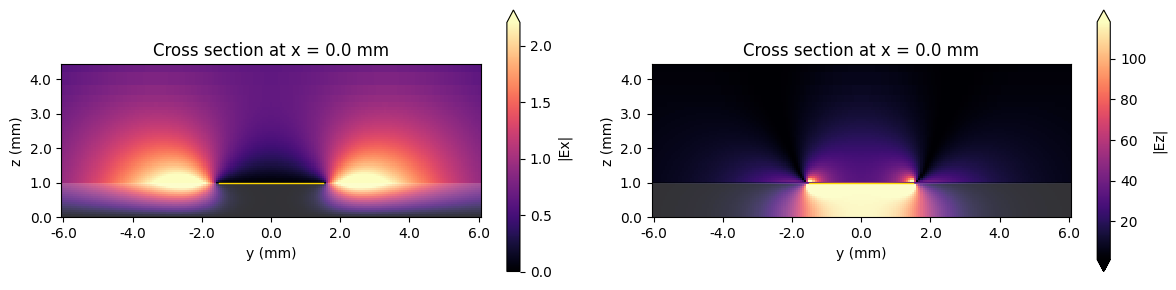

In [6]:
# Plot Ez field in the xy plane
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 3))
sim_data.plot_field(field_monitor_name="propagate", field_name="Ez", val="abs", f=freq0, ax=ax1)
update_axis_with_format(ax1, formatter, "x (mm)", "y (mm)")
ax1.set_title("Cross section at z = 0.5 mm")

# Plot both the Ex and Ez fields in the xz plane
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 3))
sim_data.plot_field(field_monitor_name="freq_yz", field_name="Ex", val="abs", f=freq0, ax=ax1)
sim_data.plot_field(field_monitor_name="freq_yz", field_name="Ez", val="abs", f=freq0, ax=ax2)
update_axis_with_format(ax1, formatter, "y (mm)", "z (mm)")
update_axis_with_format(ax2, formatter, "y (mm)", "z (mm)")
ax1.set_title("Cross section at x = 0.0 mm")
ax2.set_title("Cross section at x = 0.0 mm")
plt.show()

## Time Domain Voltage and Current

Next, we use the [VoltageIntegralAxisAligned](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.VoltageIntegralAxisAligned.html#tidy3d.plugins.microwave.VoltageIntegralAxisAligned) and [CurrentIntegralAxisAligned](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.CurrentIntegralAxisAligned.html) tools from the `microwave` plugin to compute and plot the voltage and current in the time domain.

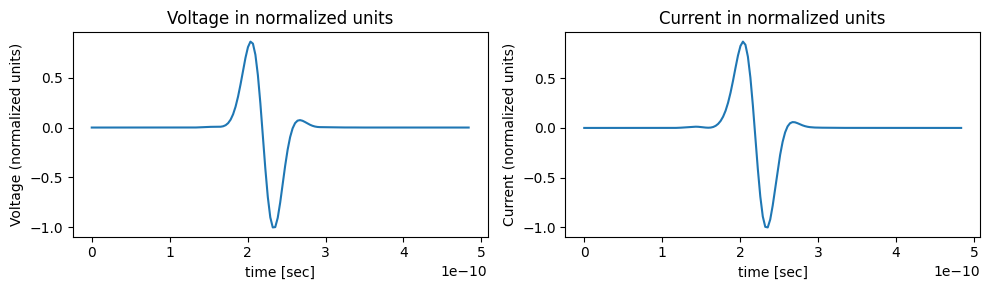

In [7]:
# Retrieve monitor data from the completed simulation
voltage_time_data = sim_data["time_voltage_yz"]
current_time_data = sim_data["time_current_yz"]

# The path for the voltage integral is defined by its center and size along a desired axis.
voltage_path = microwave.VoltageIntegralAxisAligned(
    center=(0, 0, height / 2),
    size=(0, 0, height),
    extrapolate_to_endpoints=True,  # We will explain this in the next step.
    snap_path_to_grid=True,  # If true, the path will be snapped to the Yee grid.
    sign="+",
)
# Compute voltage
voltage_time_domain = voltage_path.compute_voltage(voltage_time_data)

# The path for the current integral is defined by its center and a size.
# The contour will follow the perimeter of the rectangle defined by size.
current_path = microwave.CurrentIntegralAxisAligned(
    center=strip_center, size=(0, width + 400, 400), snap_contour_to_grid=True, sign="+"
)
# Compute current
current_time_domain = current_path.compute_current(current_time_data)

# Plot the time domain voltage and current that is observed at the x=0 position of the microstrip
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
max_voltage = max(abs(voltage_time_domain))
max_current = max(abs(current_time_domain))
(voltage_time_domain / max_voltage).plot(ax=ax1)
ax1.set_title("Voltage in normalized units")
(current_time_domain / max_current).plot(ax=ax2)
ax2.set_title("Current in normalized units")
ax1.set_ylabel("Voltage (normalized units)")
ax2.set_ylabel("Current (normalized units)")
plt.show()

One of the options for the `VoltageIntegralAxisAligned` is whether to `extrapolate_to_endpoints`. The reason for this option is to avoid problems with interpolation of the normal $\mathrm{E}$ component close to metallic interfaces, where the field is discontinuous. As an example, let's first plot the electric field between the ground and microstrip close to the peak of the time signal.

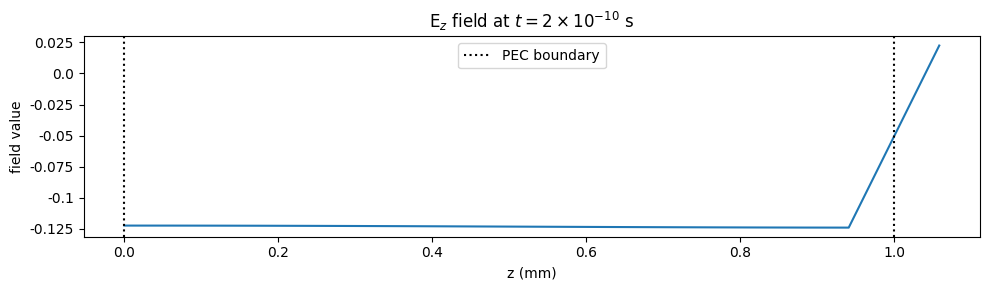

In [8]:
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
Ez_time_slice = voltage_time_data.Ez.sel(t=2e-10, x=0.0, y=0.0, method="nearest")
Ez_time_slice.plot(ax=ax1)
ax1.set_title(r"$\mathrm{E}_z$ field at $t=2 \times 10^{-10}$ s")
# Add the locations of the PEC interfaces
ax1.axvline(x=0, color="k", linestyle=":", label="PEC boundary")
ax1.axvline(x=height, color="k", linestyle=":")
update_axis_with_format(ax1, formatter, "z (mm)", "field value")
ax1.legend()
plt.show()

The discontinuity at the interface between the substrate and 2D PEC material is located at $z = 1$ mm. An accurate integration of $\mathrm{E}_z$ should extrapolate from $z < 1$ mm, since the field should remain constant up to the PEC interface.

As an example, we will be compute the voltage with `extrapolate_to_endpoints=False` and compute the relative error when compared to the original result. The error is quite small in this case, but can be worse when there are fewer Yee cells along the integration path.

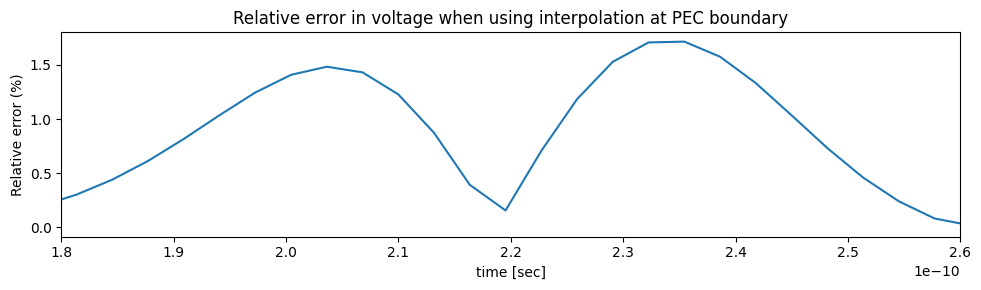

In [9]:
# Define the new voltage path object and compute voltage
voltage_path_no_extrapolate = voltage_path.updated_copy(extrapolate_to_endpoints=False)
voltage_time_domain_no_extrapolate = voltage_path_no_extrapolate.compute_voltage(voltage_time_data)

# Plot the relative error between the original voltage and the new voltage where interpolation is used near PEC interface
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.set(xlim=[1.8e-10, 2.6e-10])
voltage_max = max(abs(voltage_time_domain))
error = 100 * (abs(voltage_time_domain - voltage_time_domain_no_extrapolate) / voltage_max)
error.plot(ax=ax1)
ax1.set_title("Relative error in voltage when using interpolation at PEC boundary")
ax1.set_ylabel("Relative error (%)")
plt.show()

## Computing the Characteristic Impedance

Now, we return to the original goal of computing the characteristic impedance of the microstrip. It is more common to compute characteristic impedance in the frequency domain, which we may easily do using the [ImpedanceCalculator](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.ImpedanceCalculator.html) in the [microwave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/plugins/microwave.html) plugin. We simply reuse the definitions of the voltage and current path integrals to create an `ImpedanceCalculator` object. Then, we pass the field data associated with the frequency domain monitor identified by its name "freq_yz". The output of the `compute_impedance` function will be a data array with impedance values as a function of frequency.

Internally, the `ImpedanceCalculator` computes impedance using $Z_0 = \frac{V}{I}$ [1].

We plot the computed characteristic impedance below as a function of frequency, where we observe that the impedance increases with frequency. The propagation constant and characteristic impedance of microstrip transmission lines are known to depend on frequency, which is due to their quasi-TEM nature [1]. As a sanity check, we include the computed characteristic impedance resulting from a quasi-static model approximation.

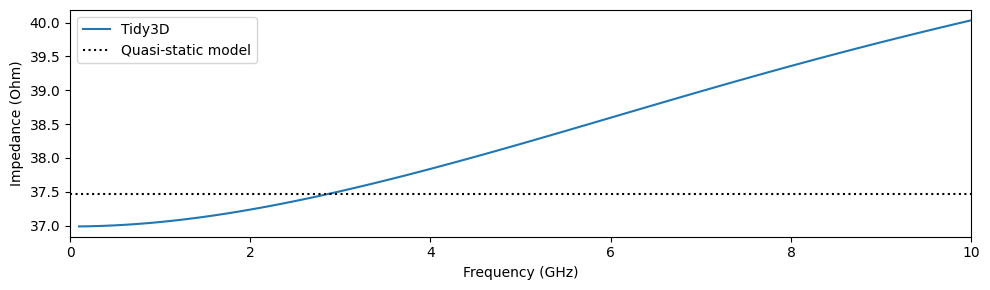

In [10]:
# Pass the voltage and current integral definitions to the impedance calculator.
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=current_path
)
# Compute impedance from frequency domain field data.
impedance = impedance_calculator.compute_impedance(sim_data["freq_yz"])

# Use a quasi-static model of the microstrip to compute an approximate value for the characteristic impedance as a sanity check.
(Zo, _) = microwave.models.microstrip.compute_line_params(4.4, width, height, thickness)

f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.plot(freqs / 1e9, abs(impedance).values, label="Tidy3D")
ax1.set_ylabel("Impedance (Ohm)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 10)
ax1.axhline(y=Zo, color="k", linestyle=":", label="Quasi-static model")
ax1.legend()
plt.show()

The quasi-static model for impedance is computed following the equations in [2], which is known to be accurate to within 0.2% for microstrips with these dimensions. As a result, the relative error of the Tidy3D simulation is approximately 1% when using the quasi-static model as a reference in the DC limit. However, the Tidy3D simulation will capture the effect of dispersion at higher frequencies, which the quasi-static model does not.

### Defining a custom path integral

Using a path integral that must be defined along an axis, as in `CurrentIntegralAxisAligned`, can be limiting in some circumstances, e.g., computing the current within the inner core of a coaxial cable. In this next part, we demonstrate the usage of `CustomCurrentIntegral2D`, which can accept any user-defined path to perform the integration. We also support `CustomVoltageIntegral2D` which can be used in the same manner.

When using a `CustomCurrentIntegral2D` or `CustomVoltageIntegral2D`, the electromagnetic fields are interpolated from the Yee grid. Therefore, to achieve good accuracy the spacing between vertices on the path should be roughly the same as, or even slightly less than, the grid spacing. On the other hand, choosing too many vertices may lead to a more expensive integration step. Finally, interpolating from fields directly on PEC or other metallic interfaces should be avoided. Hence, below we define a path that includes a small buffer distance from the strip.

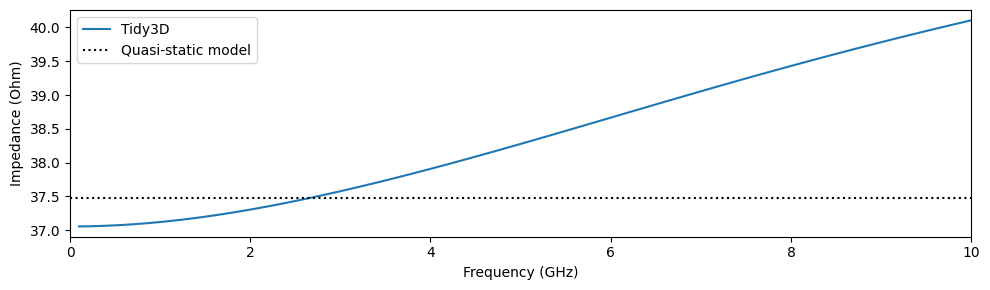

In [11]:
# Setup a path along a rectangular perimeter
Nx = 21
Ny = 11
# Add a buffer distance around the strip, to ensure that we do not interpolate from grid points on the PEC interface
buffer = 200
left = -width / 2 - buffer
right = width / 2 + buffer
bottom = height - buffer
top = height + buffer
y_bottom = np.full((1, Nx), bottom)
y_top = np.full((1, Nx), top)
x_left = np.full((1, Ny), left)
x_right = np.full((1, Ny), right)
x = np.linspace(left, right, Nx)
y = np.linspace(bottom, top, Ny)

# Concatenate the arrays of yz coordinates into a single array
xy_bottom = np.vstack((x, y_bottom))
xy_right = np.vstack((x_right, y))
xy_top = np.vstack((np.flip(x), y_top))
xy_left = np.vstack((x_left, np.flip(y)))
vertices = np.transpose(np.hstack((xy_bottom, xy_right, xy_top, xy_left)))
# Supply the CustomCurrentIntegral2D with the created vertices, along with the normal axis and position of the plane at x=0
custom_path = microwave.CustomCurrentIntegral2D(axis=0, position=0.0, vertices=vertices)
# Setup  the impedance calculator using the previously defined voltage_integral
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=custom_path
)
# Compute the impedance again in the same manner
impedance = impedance_calculator.compute_impedance(sim_data["freq_yz"])

# Plot the results for visual comparison
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.plot(freqs / 1e9, abs(impedance).values, label="Tidy3D")
ax1.set_ylabel("Impedance (Ohm)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 10)
ax1.axhline(y=Zo, color="k", linestyle=":", label="Quasi-static model")
ax1.legend()
plt.show()

The plot generated using the custom-defined path closely matches the plot from earlier, where the `CurrentIntegralAxisAligned` was used.

## Adding a Matched Load
Now that we have determined the characteristic impedance of the transmission line, we can perform a final experiment where the microstrip will be terminated by a matched load ($Z_L = Z_0$). If the impedance was computed accurately, the resulting simulation should result in small reflections from the load.

In order to model the load, the `LumpedResistor` element is be added to the simulation. We choose a resistance of 38 $\Omega$, which is roughly equal to the characteristic impedance at the central frequency of 5 GHz.

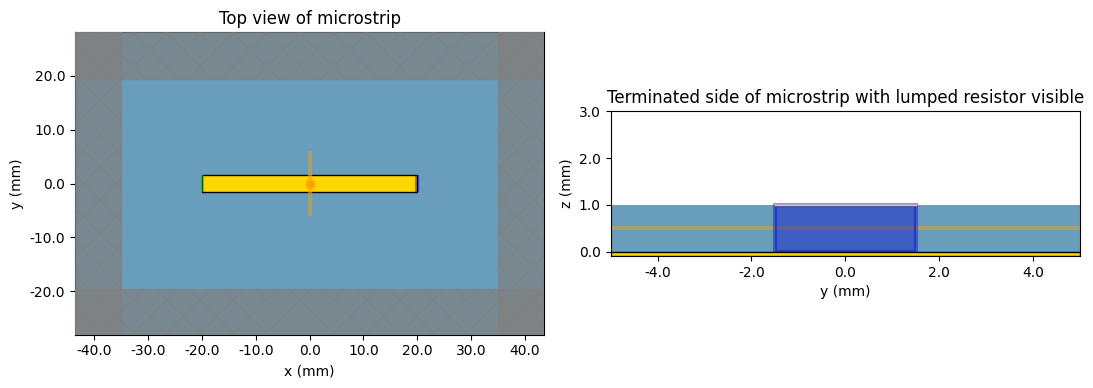

In [12]:
# Shift the center of the simulation domain so that the microstrip does not reach the PML boundary
new_center = list(sim_center)
new_center[0] = 0
# Define a resistor that will be added at the end of the microstrip.
# The lumped resistor is implemented as a 2D conductive sheet, where the conductivity is computed from
# the supplied dimensions, voltage_axis, and the desired resistance.
load = td.LumpedResistor(
    center=(length / 2, 0, height / 2),
    size=(0, width, height),
    num_grid_cells=None,
    voltage_axis=2,
    resistance=38,
    name="load",
)
sim_with_load = sim.updated_copy(center=new_center, lumped_elements=[load])


# Plot the current simulation setup and scale to millimeters
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))
sim_with_load.plot(z=height, ax=ax1)
sim_with_load.plot(x=length / 2, ax=ax2, vlim=[0, 3 * mm], hlim=[-5 * mm, 5 * mm])
update_axis_with_format(ax1, formatter, "x (mm)", "y (mm)")
ax1.set_title("Top view of microstrip")
update_axis_with_format(ax2, formatter, "y (mm)", "z (mm)")
ax2.set_title("Terminated side of microstrip with lumped resistor visible")
plt.show()

### Running the simulation

In [13]:
sim_data_with_load = web.run(sim_with_load, "impedance_calc_with_load")

12:01:09 UTC Created task 'impedance_calc_with_load' with task_id               
             'fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=905783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=275394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\taskId]8;;\]8;id=905783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\=]8;;\]8;id=156168;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\fdve]8;;\]8;id=905783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\-d9eac62d-b99]8;;\
             ]8;id=905783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\5-4ff9-b781-3903aa7d2c79']8;;\.

Output()

12:01:11 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:01:25 UTC status = preprocess

12:01:26 UTC Maximum FlexCredit cost: 0.500. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:01:42 UTC early shutoff detected at 28%, exiting.

             status = postprocess

Output()

12:01:52 UTC status = success

12:01:53 UTC View simulation result at                                          
             ]8;id=837157;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=325685;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\taskId]8;;\]8;id=837157;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\=]8;;\]8;id=544409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\fdve]8;;\]8;id=837157;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\-d9eac62d-b99]8;;\
             ]8;id=837157;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9eac62d-b995-4ff9-b781-3903aa7d2c79\5-4ff9-b781-3903aa7d2c79']8;;\.

Output()

12:01:56 UTC loading simulation from simulation_data.hdf5

First, we plot the frequency domain fields at the central frequency. Large reflections will manifest as very apparent standing waves along the x axis. In the plot below, we observe only a slight variation of the electric field along x meaning reflections are small. This indicates that the load resistor was closely matched to the characteristic impedance of the transmission line.

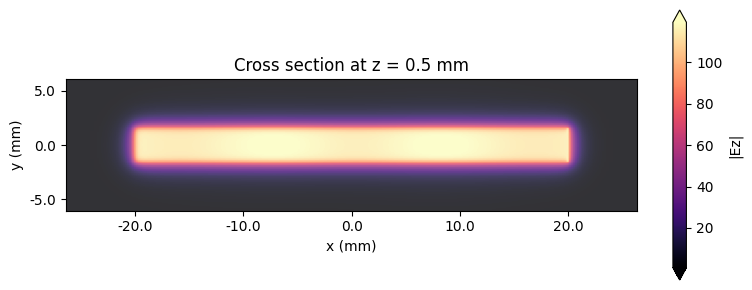

In [14]:
# Plot Ez field in the xy plane
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 3))
sim_data_with_load.plot_field(field_monitor_name="propagate", field_name="Ez", val="abs", f=freq0, ax=ax1)
update_axis_with_format(ax1, formatter, "x (mm)", "y (mm)")
ax1.set_title("Cross section at z = 0.5 mm")
plt.show()

Next, we inspect the voltage at x = 0.0 in the time domain to get a clearer view of reflections.

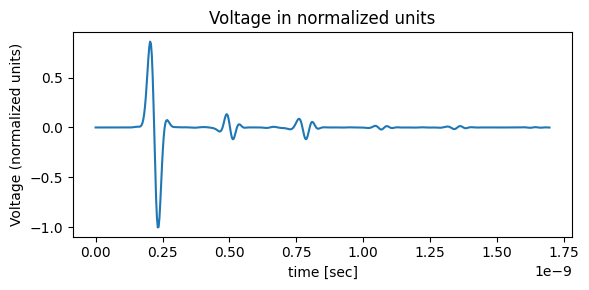

In [15]:
# Retrieve monitor data from the completed simulation
voltage_time_data = sim_data_with_load["time_voltage_yz"]
voltage_freq_data = sim_data_with_load["freq_yz"]

# The path for the voltage integral is defined by its center and size along a desired axis.
voltage_path = microwave.VoltageIntegralAxisAligned(
    center=(0, 0, height / 2),
    size=(0, 0, height),
    extrapolate_to_endpoints=True,
    snap_path_to_grid=True,  # If true, the path will be snapped to the Yee grid.
    sign="+",
)
# Compute voltage
voltage_time_domain = voltage_path.compute_voltage(voltage_time_data)

voltage_freq_domain = voltage_path.compute_voltage(voltage_freq_data)

# Plot the time domain voltage that is observed at the x = 0 position of the microstrip
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(6, 3))
max_voltage = max(abs(voltage_time_domain))
(voltage_time_domain / max_voltage).plot(ax=ax1)
ax1.set_title("Voltage in normalized units")
ax1.set_ylabel("Voltage (normalized units)")

plt.show()

In the time domain, the reflected voltage waves are easily spotted, and as expected their amplitudes are much smaller than the incident wave. Also note that the left-hand side of the microstrip was left open-circuited, which results in large reflections for waves that propagate back to the source position. As a result, multiple reflections are observed in the plot.

## References

[1]   David M. Pozar, "Microwave Network Analysis" in Microwave Engineering, 4th ed. 2011, ch. 4.

[2]   E. Hammerstad and O. Jensen, "Accurate Models for Microstrip Computer-Aided Design,"
      1980 IEEE MTT-S International Microwave Symposium Digest,
      Washington, DC, USA, 1980, pp. 407-409.